##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import keras

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

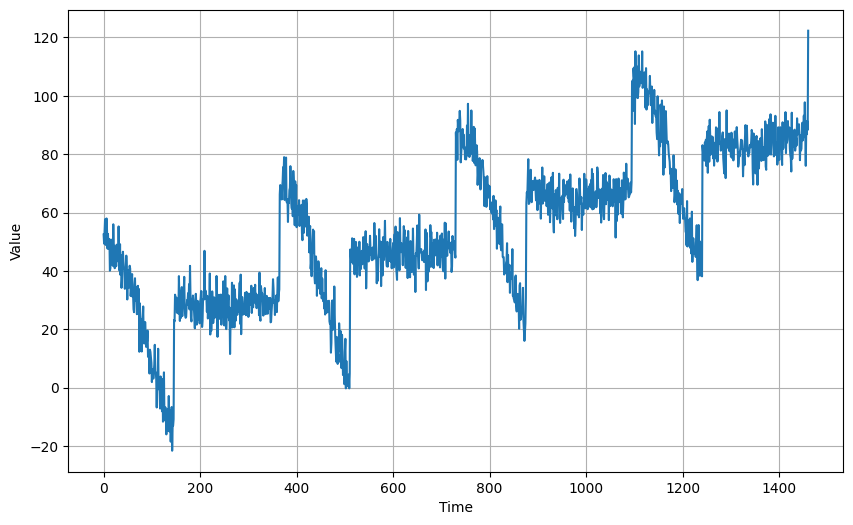

In [6]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [7]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21.2997 - mae: 21.7954 - val_loss: 11.8168 - val_mae: 12.3087
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6490 - mae: 12.1393 - val_loss: 11.6991 - val_mae: 12.1929
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.4005 - mae: 11.8927 - val_loss: 10.9084 - val_mae: 11.3990
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.0865 - mae: 11.5798 - val_loss: 9.7477 - val_mae: 10.2358
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.2596 - mae: 10.7511 - val_loss: 9.6605 - val_mae: 10.1474
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10.0172 - mae: 10.5045 - val_loss: 9.1106 - val_mae: 9.6011
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6783 - mae: 10.1663 - val_loss: 8.8172 - val_mae: 9.3055
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.5292 - mae: 10.0187 - val_loss: 8.6717 - val_mae: 9.1622
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 29.5534 - mae: 30.0517 - learning_rate: 1.0000e-06
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0219 - mae: 16.5188 - learning_rate: 1.0798e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9369 - mae: 8.4224 - learning_rate: 1.1659e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3580 - mae: 7.8480 - learning_rate: 1.2589e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4497 - mae: 7.9348 - learning_rate: 1.3594e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2806 - mae: 7.7651 - learning_rate: 1.4678e-06
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6991 - mae: 8.1842 - learning_rate: 1.5849e-06
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6873 - mae: 8.1756 - learning_rate: 1.7113e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3432 - mae: 7.8296 - learning_rate: 1.8478e-06
Epoch 10/100
31/31 ━━━━━

(1e-06, 0.001, 0.0, 20.0)

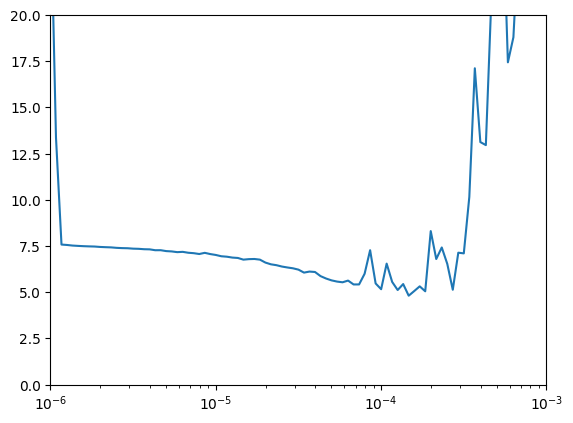

In [15]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 19.9609 - mae: 20.4520 - val_loss: 15.8315 - val_mae: 16.3227
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.9473 - mae: 17.4397 - val_loss: 15.2767 - val_mae: 15.7700
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8872 - mae: 16.3755 - val_loss: 13.4191 - val_mae: 13.9119
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.4587 - mae: 14.9501 - val_loss: 12.5041 - val_mae: 12.9937
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.4231 - mae: 12.9113 - val_loss: 11.8132 - val_mae: 12.3011
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.7850 - mae: 13.2726 - val_loss: 11.2385 - val_mae: 11.7277
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.5270 - mae: 12.0151 - val_loss: 11.4861 - val_mae: 11.9763
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.6135 - mae: 12.1057 - val_loss: 10.2576 - val_mae: 10.7508
Epoch 9/500
31/31 ━━━━━━━━━━━━━

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [19]:
lin_forecast.shape

(461,)

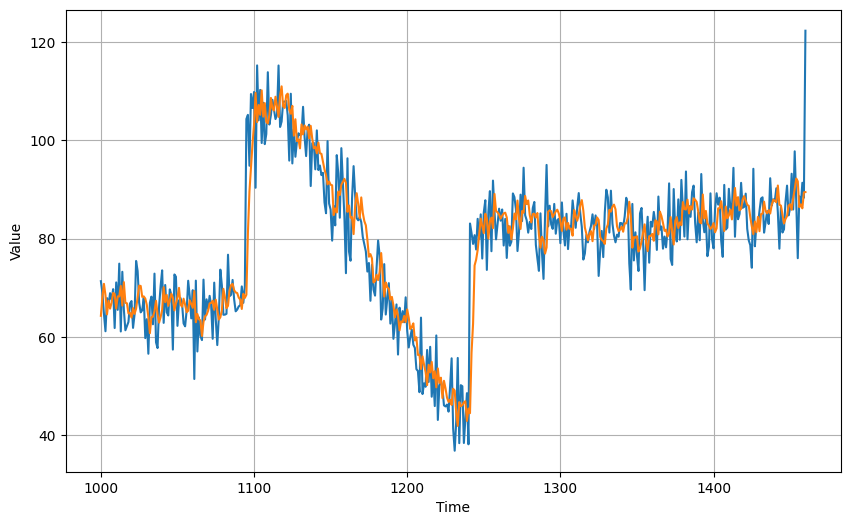

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [27]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.956053

### Dense Model Forecasting

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.3466 - mae: 14.8427 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.2073 - mae: 12.6981 - learning_rate: 1.1220e-07
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7681 - mae: 11.2598 - learning_rate: 1.2589e-07
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1716 - mae: 9.6600 - learning_rate: 1.4125e-07
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9980 - mae: 8.4894 - learning_rate: 1.5849e-07
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4649 - mae: 7.9526 - learning_rate: 1.7783e-07
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4193 - mae: 7.9004 - learning_rate: 1.9953e-07
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2145 - mae: 7.7013 - learning_rate: 2.2387e-07
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2510 - mae: 7.7345 - learning_rate: 2.5119e-07
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7870 - mae: 7.2691 - learning_rate: 2.8184e-07
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━

(1e-07, 0.005, 0.0, 30.0)

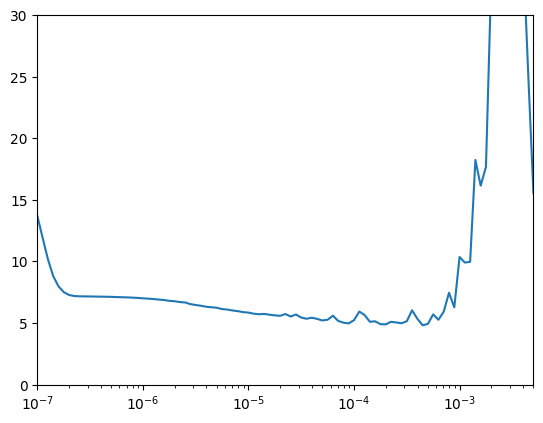

In [25]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()